In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
df = pd.read_csv('/content/azure.csv')
df.head()

,timestamp,min cpu,max cpu,avg cpu
0,2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
1,2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2,2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
3,2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
4,2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


In [5]:
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


In [6]:
train_length = round(len(df)*0.8) #finding the length of the df and multiplying it by 0.8
test_length = len(df) - train_length #test length can be found out by by subtracting the length of the df with the train data length
train = df.iloc[0:train_length] #Train dataset construction
test = df[train_length : ] #Test dataset construction

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [8]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [9]:
TIME_STEPS = 500 # Time steps are basically how many time intervals we want per sample
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.GRU(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.GRU(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 500, 512)          794112    
                                                                 
 gru_1 (GRU)                 (None, 512)               1575936   
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                                 
Total params: 2,371,587
Trainable params: 2,371,587
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [12]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [13]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

Epoch 1/10
19/19 [==============================] - 916s 48s/step - loss: 0.0667 - val_loss: 0.0321 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 897s 48s/step - loss: 0.0271 - val_loss: 0.0282 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - 960s 51s/step - loss: 0.0234 - val_loss: 0.0183 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 932s 49s/step - loss: 0.0215 - val_loss: 0.0207 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - 992s 53s/step - loss: 0.0199 - val_loss: 0.0179 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - 960s 51s/step - loss: 0.0188 - val_loss: 0.0181 - lr: 0.0010
Epoch 7/10
19/19 [==============================] - 926s 49s/step - loss: 0.0185 - val_loss: 0.0171 - lr: 0.0010
Epoch 8/10
19/19 [==============================] - 927s 49s/step - loss: 0.0179 - val_loss: 0.0176 - lr: 0.0010
Epoch 9/10
19/19 [==============================] - 952s 50s/step - loss: 0.0179 - val_loss: 0.0

In [14]:
import pickle
filename = 'GRU.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://fe8e1363-4a91-42e4-8c04-ef65a4fc5146/assets


INFO:tensorflow:Assets written to: ram://fe8e1363-4a91-42e4-8c04-ef65a4fc5146/assets


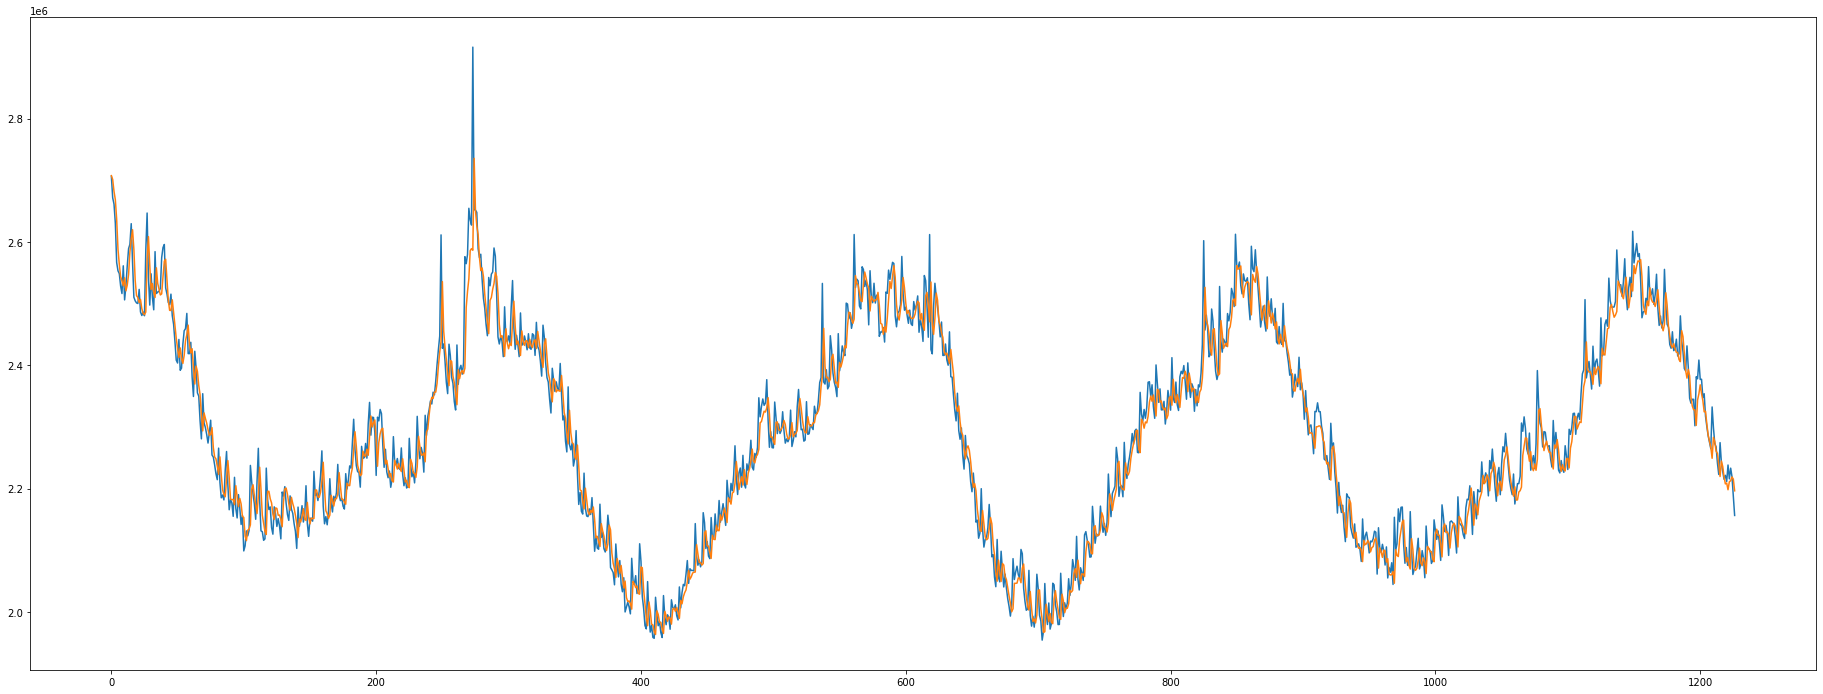

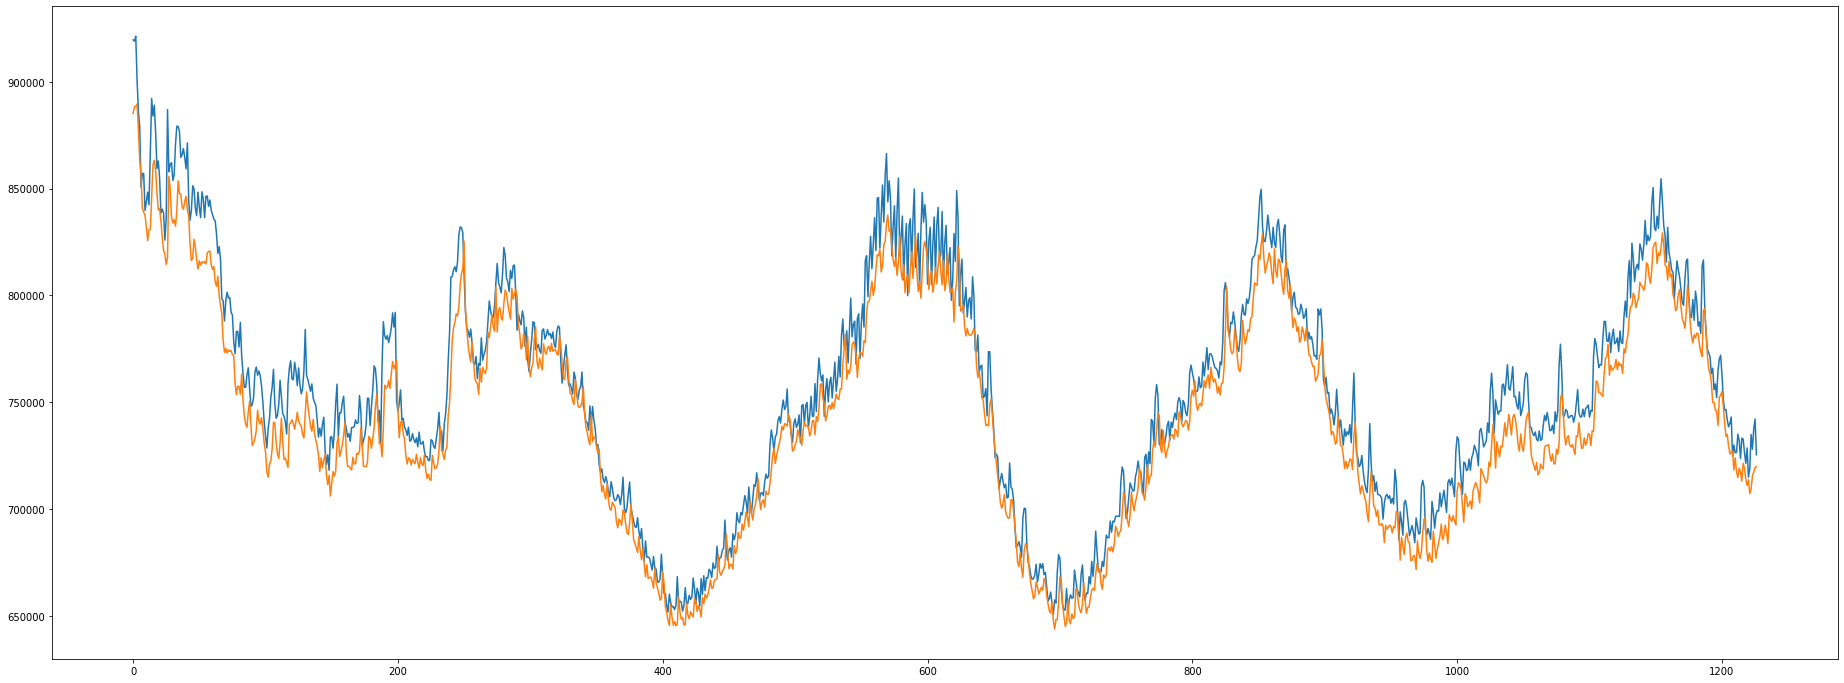

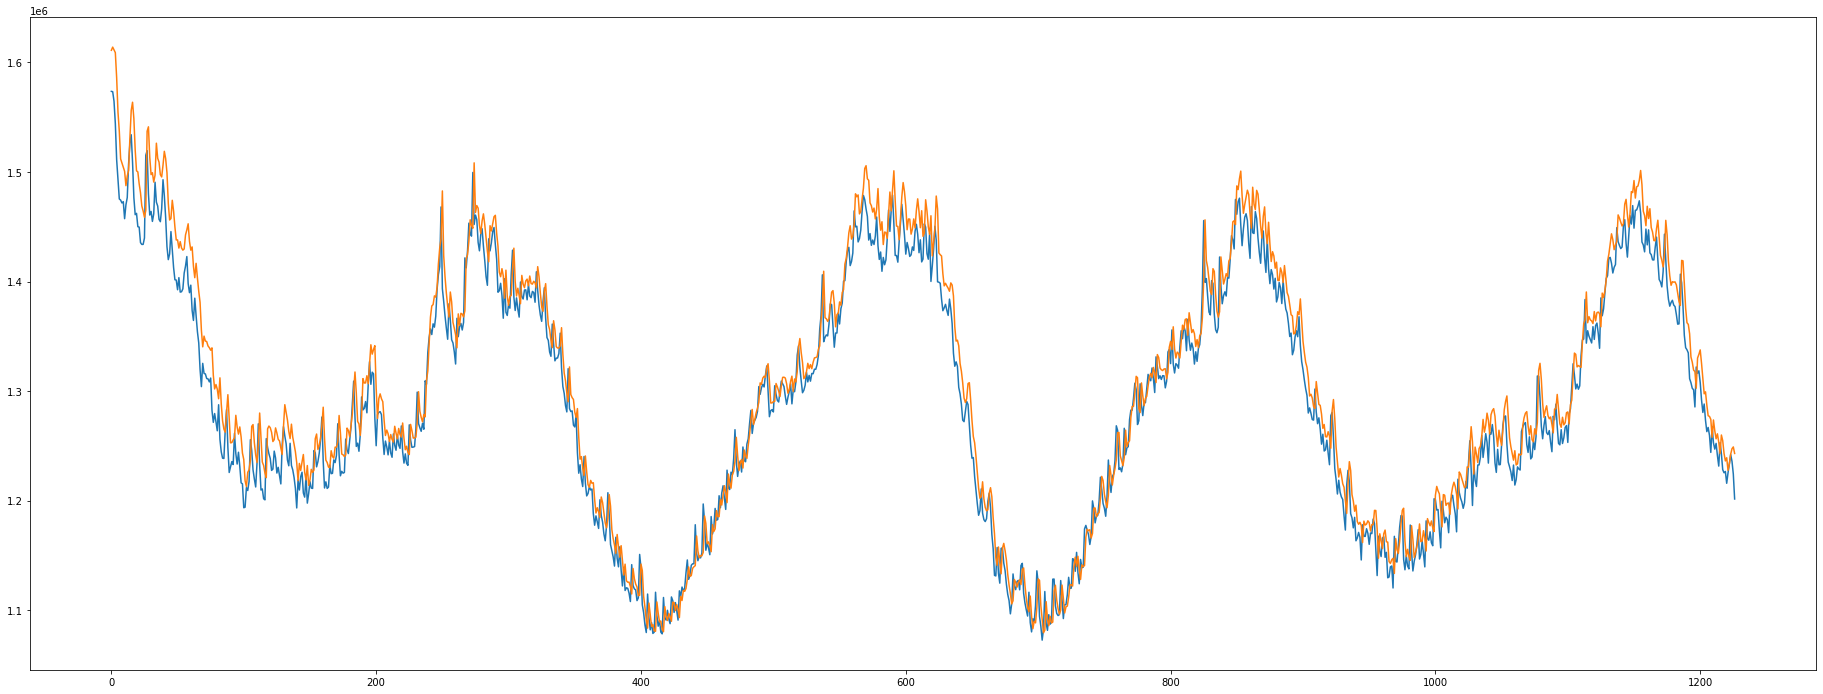

In [15]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [16]:
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 27140.04 RMSE
Test Score: 140.908592 MAE
Test Score: 1.468271 MAPE
